<a href="https://colab.research.google.com/github/onewon1234/AI_DL_Project/blob/main/koelectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset
import torch.nn as nn

In [ ]:
import itertools
import os
import transformers
import torch

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import itertools
from itertools import permutations
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import os
os.environ["WANDB_DISABLED"] = "true"
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv('../content/train.csv')
test = pd.read_csv('../content/test.csv')
submission = pd.read_csv('../content/sample_submission.csv')

In [ ]:
df = pd.read_csv("/content/train.csv")
df.head()

,ID,sentence_0,sentence_1,sentence_2,sentence_3,answer_0,answer_1,answer_2,answer_3
0,TRAIN_0000,블록체인 기술은 투표 과정의 투명성을 크게 향상시킬 수 있다.,"이러한 특성은 유권자들에게 신뢰를 제공하며, 민주적 참여를 촉진하는 데 기여할 수 있다.",결과적으로 블록체인 기반의 투표 시스템은 공정하고 신뢰할 수 있는 선거 환경을 조성...,각 투표는 변경 불가능한 기록으로 저장되어 조작의 가능성을 원천적으로 차단한다.,0,3,1,2
1,TRAIN_0001,줄거리 자동 생성의 인공지능 알고리즘은 대량의 텍스트 데이터를 분석하여 핵심 정보를...,"결과적으로, 이러한 기술은 사용자에게 신속하고 효율적인 정보 전달을 가능하게 한다.",생성된 줄거리는 원본 텍스트의 의미를 유지하면서도 간결하게 요약된 형태로 제공된다.,"이 알고리즘은 자연어 처리 기술을 활용하여 문맥을 이해하고, 주요 사건과 등장인물을...",0,3,2,1
2,TRAIN_0002,"마지막으로, 키친타올을 보관할 때는 쉽게 접근할 수 있는 곳에 두어 낭비를 방지하는...",재사용 가능한 천이나 스펀지를 활용하면 키친타올의 필요성을 줄일 수 있다.,물기를 제거할 때는 가볍게 눌러주어 과도한 사용을 피할 수 있다.,키친타올을 절약하는 첫걸음은 필요한 양만큼만 사용하는 것이다.,3,2,1,0
3,TRAIN_0003,책의 페이지가 손상되지 않도록 수직으로 세워 두거나 평평하게 눕혀 보관하는 것이 좋다.,"정기적으로 먼지를 털어내고, 곰팡이나 해충의 발생 여부를 점검하는 것이 중요하다.",종이책은 직사광선이 닿지 않는 서늘하고 건조한 장소에 보관해야 한다.,"필요할 경우, 책을 보호하기 위해 커버를 씌우거나 전용 보관함에 넣는 방법도 고려할...",2,0,1,3
4,TRAIN_0004,"인공지능 모델은 반복적인 실험을 통해 지속적으로 학습하며, 이를 통해 발견의 정확성...",인공지능은 대량의 데이터를 분석하여 숨겨진 패턴과 상관관계를 발견하는 데 강력한 도...,"결국, 인공지능의 지원은 과학적 발견의 속도와 효율성을 혁신적으로 변화시킬 수 있는...",이러한 분석 결과는 연구자들에게 새로운 가설을 제시하고 실험 설계를 개선하는 데 기...,1,3,0,2


In [ ]:
def preprocess_pairwise(df):
    data = []
    for _, row in df.iterrows():
        sentences = [row[f'sentence_{i}'] for i in range(4)]
        answer = [row[f'answer_{i}'] for i in range(4)]
        ordered = [sentences[i] for i in answer]
        positive_pairs = [(ordered[i], ordered[i+1]) for i in range(3)]
        all_pairs = list(itertools.permutations(sentences, 2))
        for s1, s2 in all_pairs:
            label = 1 if (s1, s2) in positive_pairs else 0
            data.append({'sentence1': s1, 'sentence2': s2, 'label': label})
    return pd.DataFrame(data)

In [ ]:
pairwise_df = preprocess_pairwise(df)
os.makedirs("../data", exist_ok=True)
pairwise_df.to_csv("../data/cleaned_pairwise.csv", index=False)
print("[✅] cleaned_pairwise.csv 저장 완료")

[✅] cleaned_pairwise.csv 저장 완료


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
MAX_TOKEN_LENGTH = 128

In [ ]:
class SentenceOrderDataset(df):
    def __init__(self, sentences1, sentences2, labels, tokenizer, max_length=128):
        self.sentences1 = sentences1
        self.sentences2 = sentences2
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sent1 = str(self.sentences1[idx])
        sent2 = str(self.sentences2[idx])

        encoding = self.tokenizer.encode_plus(
            sent1,
            sent2,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
class SentencePairModel(nn.Module):
    def __init__(self, model_name, num_labels=2, class_weights=None):
        super(SentencePairModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        if class_weights is not None:
            self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            output_hidden_states=True,
                            return_dict=True)

        # 마지막 4개 hidden layer 평균
        hidden_states = outputs.hidden_states  # Tuple of (layer_num, batch, seq_len, hidden)
        last_four = torch.stack(hidden_states[-4:])     # shape: (4, batch, seq_len, hidden)
        avg_hidden = torch.mean(last_four, dim=0)       # shape: (batch, seq_len, hidden)
        cls_output = avg_hidden[:, 0]                   # [CLS] 위치만 추출

        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits}

In [ ]:
def predict_sentence_order(model, tokenizer, sentences):
    """
    4개의 문장이 주어졌을 때, 가능한 문장쌍 (i, j)에 대해 모델이 i가 j보다 앞선다고 예측한 비율을 바탕으로 전체 순서를 추론합니다.
    """
    model.eval()
    device = next(model.parameters()).device
    scores = np.zeros((4, 4))

    for i, j in permutations(range(4), 2):
        inputs = tokenizer(
            sentences[i], sentences[j],
            truncation=True, padding='max_length', max_length=128,
            return_tensors='pt'
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            logits = model(**inputs).logits
            pred = torch.argmax(logits, dim=1).item()
            if pred == 1:
                scores[i][j] += 1

    order = sorted(range(4), key=lambda x: -sum(scores[x]))
    return order

In [ ]:
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds)
    }

In [ ]:
from transformers import ElectraForSequenceClassification

model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-discriminator")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import ElectraModel, ElectraTokenizer

# KoELECTRA-Base
model = ElectraModel.from_pretrained("monologg/koelectra-base-discriminator")
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-discriminator")

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/279k [00:00<?, ?B/s]

In [ ]:
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

# preprocess_pairwise 함수는 DataFrame을 반환하므로 하나로 받습니다.
train_pairwise_df =  preprocess_pairwise(train_df)
val_pairwise_df =  preprocess_pairwise(val_df)

In [ ]:
train_dataset = SentencePairModel(
    sentences1=train_pairwise_df['sentence1'].tolist(), # sentence1 컬럼을 리스트로 변환하여 전달
    sentences2=train_pairwise_df['sentence2'].tolist(), # sentence2 컬럼을 리스트로 변환하여 전달
    labels=train_pairwise_df['label'].tolist(),         # label 컬럼을 리스트로 변환하여 전달
    tokenizer=tokenizer,
    max_length=MAX_TOKEN_LENGTH
)
val_dataset = SentencePairModel(
    sentences1=val_pairwise_df['sentence1'].tolist(),
    sentences2=val_pairwise_df['sentence2'].tolist(),
    labels=val_pairwise_df['label'].tolist(),
    tokenizer=tokenizer,
    max_length=MAX_TOKEN_LENGTH
)

TypeError: SentencePairModel.__init__() got an unexpected keyword argument 'sentences1'

In [ ]:
# corrected SentenceOrderDataset definition
class SentenceOrderDataset(Dataset): # Inherit from torch.utils.data.Dataset
    def __init__(self, sentences1, sentences2, labels, tokenizer, max_length=128):
        self.sentences1 = sentences1
        self.sentences2 = sentences2
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sent1 = str(self.sentences1[idx])
        sent2 = str(self.sentences2[idx])

        encoding = self.tokenizer.encode_plus(
            sent1,
            sent2,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# データ分할: 학습/검증 (예: 8:2)
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

# preprocess_pairwise 함수는 DataFrame을 반환하므로 하나로 받습니다.
train_pairwise_df =  preprocess_pairwise(train_df)
val_pairwise_df =  preprocess_pairwise(val_df)

# dataset 생성 시 DataFrame에서 문장과 레이블 컬럼을 전달합니다.
train_dataset = SentenceOrderDataset(
    sentences1=train_pairwise_df['sentence1'].tolist(), # sentence1 컬럼을 리스트로 변환하여 전달
    sentences2=train_pairwise_df['sentence2'].tolist(), # sentence2 컬럼을 리스트로 변환하여 전달
    labels=train_pairwise_df['label'].tolist(),         # label 컬럼을 리스트로 변환하여 전달
    tokenizer=tokenizer,
    max_length=MAX_TOKEN_LENGTH
)
val_dataset = SentenceOrderDataset(
    sentences1=val_pairwise_df['sentence1'].tolist(),
    sentences2=val_pairwise_df['sentence2'].tolist(),
    labels=val_pairwise_df['label'].tolist(),
    tokenizer=tokenizer,
    max_length=MAX_TOKEN_LENGTH
)

In [ ]:
# 데이터 분할: 학습/검증 (예: 8:2)
train_df, val_df = train_test_split(pairwise_df, test_size=0.2, stratify=pairwise_df['label'], random_state=42)

# dataset 생성
train_dataset = SentencePairDataset(train_df, tokenizer, max_length=MAX_TOKEN_LENGTH)
val_dataset = SentencePairDataset(val_df, tokenizer, max_length=MAX_TOKEN_LENGTH)

TypeError: 'DataFrame' object is not callable

In [ ]:
# 모델 및 학습 설정
model = AutoModelForSequenceClassification.from_pretrained(model, num_labels=2)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,                     # 최대 에폭 수
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",           # 에폭마다 평가
    save_strategy="epoch",                 # 에폭마다 저장
    load_best_model_at_end=True,           # 가장 좋은 모델 복원
    metric_for_best_model="eval_f1",       # F1 기준
    greater_is_better=True,
    save_total_limit=1,                    # 디스크 공간 아끼기
    learning_rate=2e-5,                    # 학습률 줄임 (기존 5e-5 → 2e-5)
    weight_decay=0.01,                     # 정규화로 과적합 방지
    logging_dir='./logs',                  # 로그 저장 폴더
    logging_steps=100,                     # 몇 step마다 로깅할지
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,        # 정확도, f1 등 평가 함수
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # Early stopping
)

HFValidationError: Repo id must use alphanumeric chars or '-', '_', '.', '--' and '..' are forbidden, '-' and '.' cannot start or end the name, max length is 96: 'ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(32200, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0-11): 12 x ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=3072, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
)'.

In [ ]:
# 모델 및 학습 설정
# model 변수에 ElectraModel 인스턴스 대신 모델 이름을 문자열로 전달합니다.
model_name = "monologg/koelectra-base-discriminator"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,                     # 최대 에폭 수
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",           # 에폭마다 평가
    save_strategy="epoch",                 # 에폭마다 저장
    load_best_model_at_end=True,           # 가장 좋은 모델 복원
    metric_for_best_model="eval_f1",       # F1 기준
    greater_is_better=True,
    save_total_limit=1,                    # 디스크 공간 아끼기
    learning_rate=2e-5,                    # 학습률 줄임 (기존 5e-5 → 2e-5)
    weight_decay=0.01,                     # 정규화로 과적합 방지
    logging_dir='./logs',                  # 로그 저장 폴더
    logging_steps=100,                     # 몇 step마다 로깅할지
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,        # 정확도, f1 등 평가 함수
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # Early stopping
)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-29-b0d98961d4cd>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_result = trainer.train()
eval_result = trainer.evaluate()
print("\n[Validation Metrics]")
for k, v in eval_result.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.330600,0.339010,0.846816,0.693285,0.694072,0.692499
2,0.228500,0.396205,0.858260,0.728751,0.698607,0.761613
3,0.169400,0.489930,0.862112,0.723346,0.725656,0.721051



[Validation Metrics]
eval_loss: 0.3962
eval_accuracy: 0.8583
eval_f1: 0.7288
eval_precision: 0.6986
eval_recall: 0.7616
eval_runtime: 136.6032
eval_samples_per_second: 129.2210
eval_steps_per_second: 8.0820
epoch: 3.0000


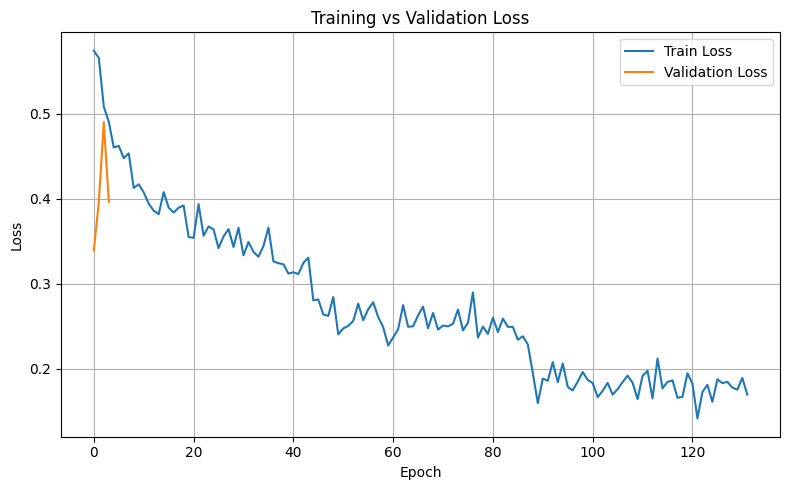

In [ ]:
train_log = trainer.state.log_history
train_losses = [x['loss'] for x in train_log if 'loss' in x]
eval_losses = [x['eval_loss'] for x in train_log if 'eval_loss' in x]

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 예측 예시
example = [
    "문장 A입니다.",
    "문장 B입니다.",
    "문장 C입니다.",
    "문장 D입니다."
]
predicted_order = predict_sentence_order(model, tokenizer, example)
print("예측된 순서:", predicted_order)


예측된 순서: [0, 1, 2, 3]


In [ ]:
import nbformat

# 경로 설정
input_path = 'path/to/original_notebook.ipynb'
output_path = 'path/to/cleaned_notebook.ipynb'

# 노트북 로드
with open(input_path, 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)

# 모든 셀에서 widgets 메타데이터 제거
for cell in nb.cells:
    if 'metadata' in cell and 'widgets' in cell['metadata']:
        del cell['metadata']['widgets']

# 전체 노트북 메타데이터에서 widgets 제거
if 'widgets' in nb['metadata']:
    del nb['metadata']['widgets']

# 저장
with open(output_path, 'w', encoding='utf-8') as f:
    nbformat.write(nb, f)


FileNotFoundError: [Errno 2] No such file or directory: 'path/to/original_notebook.ipynb'